In [1]:
# =============================================================================
# SIMULAÇÃO ELETROTÉRMICA DE FUSÍVEL AUTOMOTIVO 40A
# ETAPA 1: PROBLEMA ELÉTRICO E TÉRMICO DESACOPLADO
# =============================================================================

import numpy as np
import gmsh
import pyvista
import ufl
from mpi4py import MPI
from petsc4py import PETSc
import matplotlib.pyplot as plt

# Imports do FEniCS/DOLFINx
from dolfinx import default_scalar_type, fem
from dolfinx.fem import (
    Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_topological, Expression
)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import gmshio
from dolfinx.mesh import locate_entities_boundary, meshtags, exterior_facet_indices
from dolfinx.plot import vtk_mesh

In [2]:
# =============================================================================
# 1. PARÂMETROS DA SIMULAÇÃO E PROPRIEDADES DOS MATERIAIS
# =============================================================================

# --- Parâmetros Elétricos
I_nominal = 40.0      # (A) Corrente nominal do fusível 40A
V0 = 0.1              # (V) Tensão para a simulação inicial

# --- Geometria do Fusível (m) - Conforme modelo do usuário
x_bar = 5.2e-3
y_bar = 16.3e-3
x_gap = 4.1e-3
y_filamento = 6.5e-4
espessura_lamina = 6.5e-4 # Adicionado: Espessura fora do plano, crucial para o cálculo da corrente

# --- Propriedades do Material (Estanho)
sigma_e = 8.7e6       # (S/m) Condutividade elétrica
alpha_r = 0.0045      # (1/K) Coeficiente de temperatura da resistividade
rho = 7298.0          # (kg/m³) Densidade
Cp = 227.0            # (J/kg⋅K) Calor específico
k_thermal = 66.6      # (W/m⋅K) Condutividade térmica
Tf = 231.97 + 273.15  # (K) Temperatura de fusão

# --- Condições Ambientais
T_amb = 25.0 + 273.15 # (K) Temperatura ambiente
h_conv = 15.0         # (W/m²⋅K) Coeficiente de convecção para superfícies em contato com o ar

# --- Configurações da Simulação
comm = MPI.COMM_WORLD
gdim = 2
model_rank = 0

In [3]:
# =============================================================================
# 2. CRIAÇÃO DA GEOMETRIA E MALHA
# =============================================================================

def geometria(x_gap):
    """
    Cria a geometria 2D do fusível automotivo (modelo original do usuário).
    """
    gmsh.initialize()
    if comm.rank == model_rank:
        gmsh.model.add("fusivel")
        
        terminal1 = gmsh.model.occ.addRectangle(0, 0, 0, x_bar, y_bar)
        terminal2 = gmsh.model.occ.addRectangle(x_bar + x_gap, 0, 0, x_bar, y_bar)

        y_filamento_pos = y_bar * 0.4 

        f1 = gmsh.model.occ.addRectangle(x_bar, y_filamento_pos, 0, x_gap / 4, y_filamento)
        f2 = gmsh.model.occ.addRectangle(x_bar + 3 * x_gap / 4, y_filamento_pos, 0, x_gap / 4, y_filamento)
        f3 = gmsh.model.occ.addRectangle(x_bar + x_gap / 4 - y_filamento, y_filamento_pos + y_filamento, 0, y_filamento, y_bar * 0.2)
        f4 = gmsh.model.occ.addRectangle(x_bar + 3 * x_gap / 4, y_filamento_pos + y_filamento, 0, y_filamento, y_bar * 0.2)
        f5 = gmsh.model.occ.addRectangle(x_bar + x_gap / 4, y_filamento_pos + y_bar * 0.2, 0, x_gap / 2, y_filamento)
        entidades = [(2, terminal1), (2, terminal2), (2, f1), (2, f2), (2, f3), (2, f4), (2, f5)]
        _, omap = gmsh.model.occ.fragment(entidades, [])
        gmsh.model.occ.synchronize()

        vols = gmsh.model.getEntities(dim=2)
        terminal1_ids, terminal2_ids, filamento_ids = [], [], []
        for vol in vols:
            com = gmsh.model.occ.getCenterOfMass(vol[0], vol[1])
            if com[0] < x_bar:
                terminal1_ids.append(vol[1])
            elif com[0] > x_bar + x_gap:
                terminal2_ids.append(vol[1])
            else:
                filamento_ids.append(vol[1])
        
        gmsh.model.addPhysicalGroup(2, terminal1_ids, 1); gmsh.model.setPhysicalName(2, 1, "Terminal1")
        gmsh.model.addPhysicalGroup(2, terminal2_ids, 2); gmsh.model.setPhysicalName(2, 2, "Terminal2")
        gmsh.model.addPhysicalGroup(2, filamento_ids, 3); gmsh.model.setPhysicalName(2, 3, "Filamento")
        
        gmsh.option.setNumber("Mesh.CharacteristicLengthMax", x_gap / 16)
        gmsh.model.mesh.generate(gdim)
        
        mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, comm, model_rank, gdim=gdim)
    else:
        mesh, cell_tags, facet_tags = gmshio.model_to_mesh(None, comm, model_rank, gdim=gdim)
        
    gmsh.finalize()
    return mesh, cell_tags, facet_tags

mesh, cell_tags, facet_tags = geometria(x_gap)

Info    : Meshing 1D...                                                                                                                         
Info    : [  0%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 40%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%] Meshing curve 24 (Line)
Info    : [ 50%] Meshing curve 25 (Line)
Info    : [ 50%] Meshing curve 26 (Line)
Info    : [ 50%] Meshing curve 27 (Line)
Info    : [ 60%] Meshing curve 28 (Line)
Info    : [ 60%] Meshing curve 29 (Line)
Info    : [ 60%] Meshing curve 30 (Line)
Info    : [ 70%] Meshing curve 31 (Line)
Info    : [ 70%] Meshing curve 32 (Line)
Info    : [ 70%] Meshing curve 33 (

In [4]:
# =============================================================================
# 3. CONFIGURAÇÃO DOS PROBLEMAS E ESPAÇOS DE FUNÇÃO
# =============================================================================

V_ele = functionspace(mesh, ("Lagrange", 1)) # Espaço para Potencial Elétrico
V_T = functionspace(mesh, ("Lagrange", 1))   # Espaço para Temperatura
Q = functionspace(mesh, ("DG", 0))           # Espaço para propriedades constantes por célula
W_ele = functionspace(mesh, ("Lagrange", 1, (gdim,))) # Espaço vetorial para E

# --- Funções para armazenar soluções e propriedades ---
phi_sol = Function(V_ele, name="Potencial_Eletrico")
T_sol = Function(V_T, name="Temperatura")
T_n = Function(V_T, name="Temperatura_passo_anterior") # Temperatura no passo de tempo n-1
mu = Function(Q, name="Condutividade_Eletrica")
q_source = Function(Q, name="Fonte_Calor")
E_field = Function(W_ele, name="Campo_Eletrico")

mu.x.array[:] = sigma_e # Condutividade inicial

In [5]:
# =============================================================================
# 4. DEFINIÇÃO DAS CONDIÇÕES DE CONTORNO
# =============================================================================

# --- Elétrica e Térmica na Base (y=0) ---
facets_base = locate_entities_boundary(mesh, gdim - 1, lambda x: np.isclose(x[1], 0))
dofs_base_ele = locate_dofs_topological(V_ele, gdim - 1, facets_base)
uD = Function(V_ele)
uD.interpolate(lambda x: np.where(x[0] < x_bar + x_gap / 2, V0, 0))
bc_ele = dirichletbc(uD, dofs_base_ele)

T_amb_const = Constant(mesh, default_scalar_type(T_amb))
dofs_base_term = locate_dofs_topological(V_T, gdim - 1, facets_base)
bc_term = dirichletbc(T_amb_const, dofs_base_term, V_T)

# --- Térmica: Convecção nas outras fronteiras ---
boundary_facets = exterior_facet_indices(mesh.topology)
convection_facets = np.setdiff1d(boundary_facets, facets_base)
convection_tags = meshtags(mesh, gdim-1, convection_facets, 1)
ds_conv = ufl.ds(domain=mesh, subdomain_data=convection_tags, subdomain_id=1)

In [6]:
# =============================================================================
# 5. SIMULAÇÃO ELETROTÉRMICA
# =============================================================================

# --- Problema Elétrico ---
phi = ufl.TrialFunction(V_ele)
v = ufl.TestFunction(V_ele)
a_ele_st = mu * ufl.dot(ufl.grad(phi), ufl.grad(v)) * ufl.dx
L_ele_st = Constant(mesh, default_scalar_type(0.0)) * v * ufl.dx
problem_ele_st = LinearProblem(a_ele_st, L_ele_st, bcs=[bc_ele], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
phi_sol = problem_ele_st.solve()

# --- Pós-processamento Elétrico ---
E_expr_ufl = -ufl.grad(phi_sol)
E_expr_fem = Expression(E_expr_ufl, W_ele.element.interpolation_points())
E_field.interpolate(E_expr_fem)
power_form = form(mu * ufl.dot(E_field, E_field) * ufl.dx)
power_dissipated = assemble_scalar(power_form) * espessura_lamina
I_total_calculada = (power_dissipated / V0) if V0 != 0 else 0
R_eff = V0 / abs(I_total_calculada) if I_total_calculada != 0 else 0

print("\n" + "="*50)
print("RESULTADOS DA SIMULAÇÃO)")
print(f"Tensão (V0) aplicada na base: {V0:.2f} V")
print(f"Corrente total calculada: {abs(I_total_calculada):.2f} A")
print(f"Resistência efetiva do modelo: {R_eff * 1000:.4f} mΩ")
print("="*50)

# --- Problema Térmico Estacionário ---
T_st = ufl.TrialFunction(V_T)
w_st = ufl.TestFunction(V_T)
q_source_st = Function(Q)
q_expr_ufl_st = mu * ufl.dot(E_field, E_field)
q_expr_fem_st = Expression(q_expr_ufl_st, Q.element.interpolation_points())
q_source_st.interpolate(q_expr_fem_st)
k_const = Constant(mesh, default_scalar_type(k_thermal))
h_const = Constant(mesh, default_scalar_type(h_conv))

a_T_st = (k_const * ufl.dot(ufl.grad(T_st), ufl.grad(w_st)) * ufl.dx 
          + h_const * T_st * w_st * ds_conv(1)
          + (2 * h_const / espessura_lamina) * T_st * w_st * ufl.dx)

L_T_st = (q_source_st * w_st * ufl.dx 
          + h_const * T_amb_const * w_st * ds_conv(1)
          + (2 * h_const / espessura_lamina) * T_amb_const * w_st * ufl.dx)

problem_T_st = LinearProblem(a_T_st, L_T_st, bcs=[bc_term], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
T_sol = problem_T_st.solve()

print("\n" + "="*50)
print("RESULTADOS DA SIMULAÇÃO TÉRMICA")
print(f"Temperatura Mínima: {T_sol.x.array.min():.2f} K ({(T_sol.x.array.min() - 273.15):.2f} °C)")
print(f"Temperatura Máxima: {T_sol.x.array.max():.2f} K ({(T_sol.x.array.max() - 273.15):.2f} °C)")
print(f"Temperatura de Fusão do Estanho: {Tf:.2f} K ({(Tf - 273.15):.2f} °C)")
print("="*50 + "\n")


RESULTADOS DA SIMULAÇÃO)
Tensão (V0) aplicada na base: 0.10 V
Corrente total calculada: 30.69 A
Resistência efetiva do modelo: 3.2581 mΩ

RESULTADOS DA SIMULAÇÃO TÉRMICA
Temperatura Mínima: 298.15 K (25.00 °C)
Temperatura Máxima: 455.39 K (182.24 °C)
Temperatura de Fusão do Estanho: 505.12 K (231.97 °C)



error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


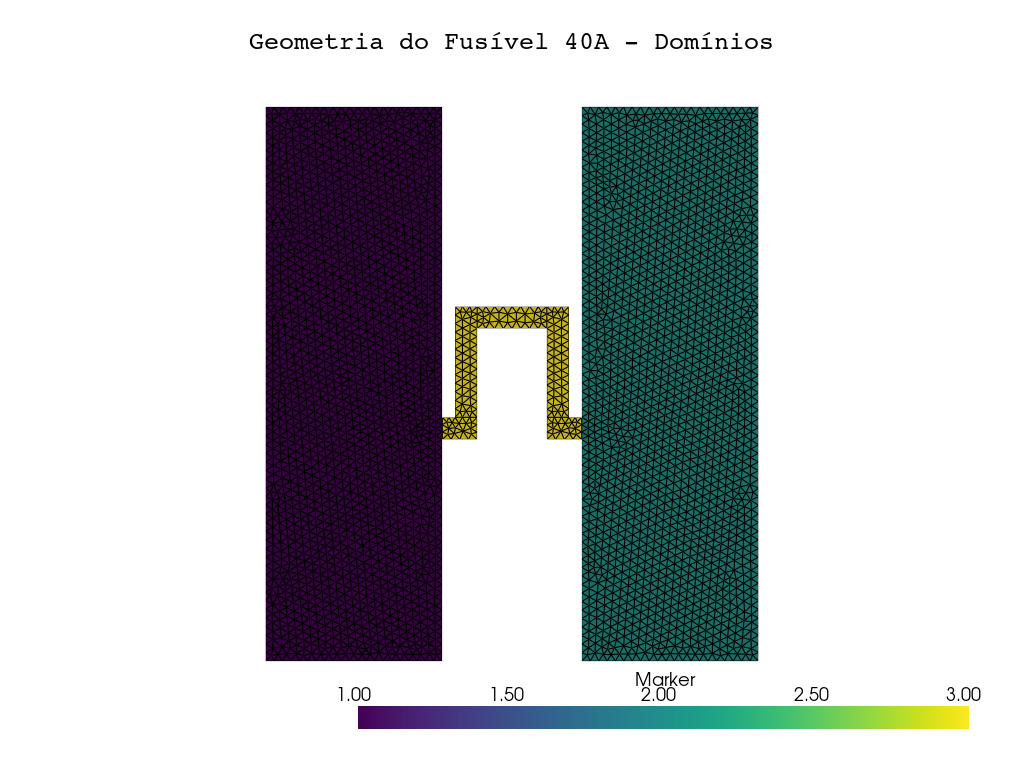

Geometria criada: Terminal1 (roxo) - Filamento (amarelo) - Terminal2 (verde)


error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


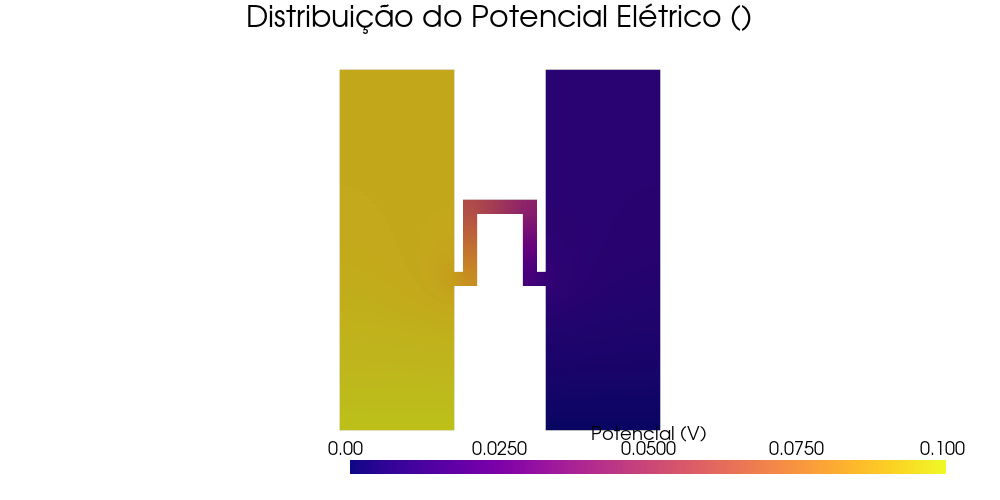

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


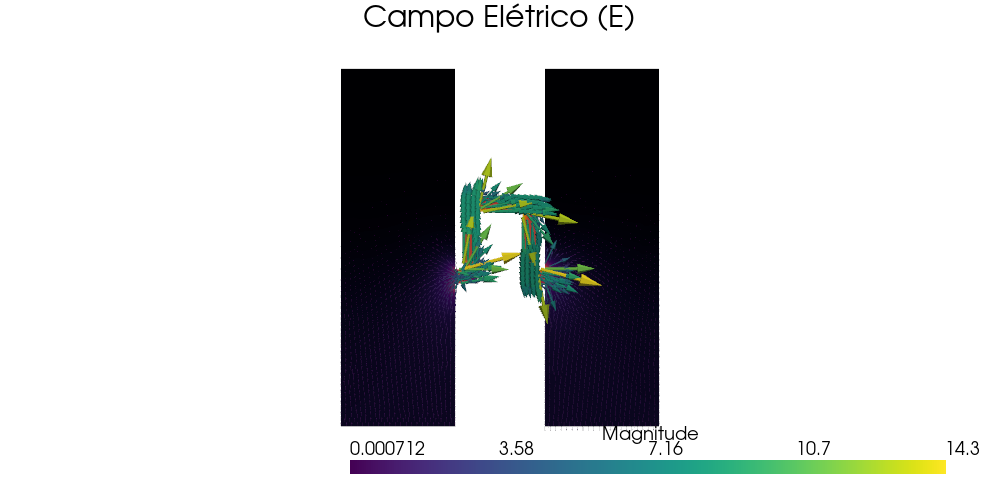

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


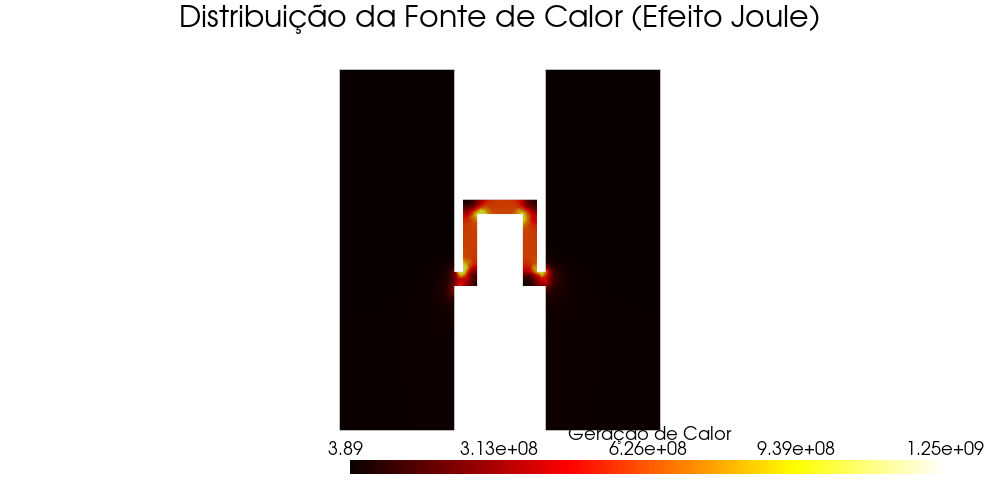

error: XDG_RUNTIME_DIR is invalid or not set in the environment.
MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


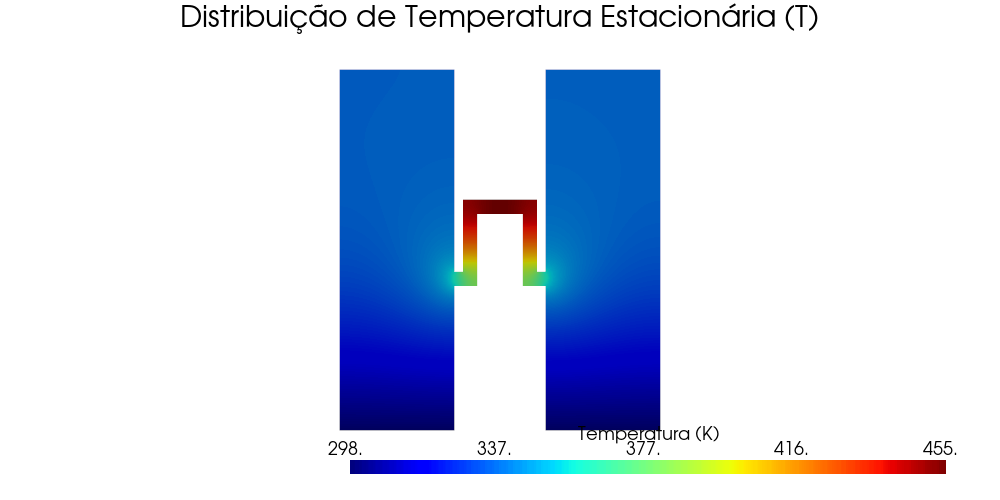

In [ ]:
# =============================================================================
# 6. PLOTS DE VISUALIZAÇÃO
# =============================================================================
pyvista.start_xvfb()

# --- Visualização da Geometria ---
plotter_geom = pyvista.Plotter()
grid_geom = pyvista.UnstructuredGrid(*vtk_mesh(mesh, gdim))
num_local_cells = mesh.topology.index_map(gdim).size_local
grid_geom.cell_data["Marker"] = cell_tags.values[cell_tags.indices < num_local_cells]
grid_geom.set_active_scalars("Marker")
plotter_geom.add_mesh(grid_geom, show_edges=True, cmap="viridis", edge_color="black")
plotter_geom.add_title('Geometria do Fusível 40A - Domínios', font='courier', color='k', font_size=10)
plotter_geom.view_xy()
plotter_geom.show()
print('Geometria criada: Terminal1 (roxo) - Filamento (amarelo) - Terminal2 (verde)')

# --- Visualização do Potencial Elétrico ---
plotter_phi = pyvista.Plotter(window_size=[1000, 500])
grid_phi = pyvista.UnstructuredGrid(*vtk_mesh(V_ele))
grid_phi.point_data["Potencial (V)"] = phi_sol.x.array
plotter_phi.add_mesh(grid_phi, show_edges=False, cmap="plasma")
plotter_phi.add_text("Distribuição do Potencial Elétrico (φ)", position="upper_edge", font_size=12, color="black")
plotter_phi.view_xy()
plotter_phi.show()

# --- Visualização do Campo Elétrico ---
plotter_E = pyvista.Plotter(window_size=[1000, 500])
# Cria a grade para o plot
grid_E = pyvista.UnstructuredGrid(*vtk_mesh(W_ele))
vectors_2d = E_field.x.array.reshape(-1, 2)
vectors_3d = np.zeros((vectors_2d.shape[0], 3))
vectors_3d[:, :2] = vectors_2d
grid_E.point_data["Campo Elétrico"] = vectors_3d
# Adiciona a magnitude como escalar para a cor
grid_E["Magnitude"] = np.linalg.norm(vectors_2d, axis=1)
# Adiciona o mapa de cores de fundo
plotter_E.add_mesh(grid_E, scalars="Magnitude", cmap="inferno")
# Adiciona os glifos (setas)
glyphs = grid_E.glyph(orient="Campo Elétrico", factor=2e-4)
plotter_E.add_mesh(glyphs)
plotter_E.add_text("Campo Elétrico (E)", position="upper_edge", font_size=12, color="black")
plotter_E.view_xy()
plotter_E.show()

# --- Visualização da Fonte de Calor (Efeito Joule) ---
plotter_q = pyvista.Plotter(window_size=[1000, 500])
# Projeta a fonte de calor (DG-0) para um espaço contínuo (Lagrange-1) para visualização
V_plot = functionspace(mesh, ("Lagrange", 1))
q_plot = Function(V_plot)
u_plot, v_plot = ufl.TrialFunction(V_plot), ufl.TestFunction(V_plot)
a_q_plot = u_plot * v_plot * ufl.dx
L_q_plot = q_source_st * v_plot * ufl.dx
problem_q_plot = LinearProblem(a_q_plot, L_q_plot, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
q_plot.x.array[:] = problem_q_plot.solve().x.array
# Cria a grade para o plot
grid_q = pyvista.UnstructuredGrid(*vtk_mesh(V_plot))
grid_q.point_data["Fonte de Calor (W/m^3)"] = q_plot.x.array
plotter_q.add_mesh(grid_q, show_edges=False, cmap="hot", scalar_bar_args={'title': 'Geração de Calor'})
plotter_q.add_text("Distribuição da Fonte de Calor (Efeito Joule)", position="upper_edge", font_size=12, color="black")
plotter_q.view_xy()
plotter_q.show()

# --- Visualização da Temperatura ---
plotter_T = pyvista.Plotter(window_size=[1000, 500])
grid_T = pyvista.UnstructuredGrid(*vtk_mesh(V_T))
grid_T.point_data["Temperatura (K)"] = T_sol.x.array
plotter_T.add_mesh(grid_T, show_edges=False, cmap="jet")
plotter_T.add_text("Distribuição de Temperatura Estacionária (T)", position="upper_edge", font_size=12, color="black")
plotter_T.view_xy()
plotter_T.show()

In [8]:
# =============================================================================
# 7. ANÁLISE TRANSIENTE (TEMPO vs TEMPERATURA)
# =============================================================================

print("\nIniciando análise transiente para diferentes correntes...")

currents_to_test = np.linspace(5, 40, 8) 
t_final = 5.0
results = {}

# --- Preparação para o loop transiente ---
T_tr = ufl.TrialFunction(V_T)
w_tr = ufl.TestFunction(V_T)
dt = Constant(mesh, default_scalar_type(0.05))
rho_const = Constant(mesh, default_scalar_type(rho))
Cp_const = Constant(mesh, default_scalar_type(Cp))

a_T_tr = ((rho_const * Cp_const * T_tr / dt) * w_tr * ufl.dx 
          + k_const * ufl.dot(ufl.grad(T_tr), ufl.grad(w_tr)) * ufl.dx 
          + h_const * T_tr * w_tr * ds_conv(1)
          + (2 * h_const / espessura_lamina) * T_tr * w_tr * ufl.dx)

L_T_tr_base = ((rho_const * Cp_const * T_n / dt) * w_tr * ufl.dx 
               + h_const * T_amb_const * w_tr * ds_conv(1)
               + (2 * h_const / espessura_lamina) * T_amb_const * w_tr * ufl.dx)

for i_target in currents_to_test:
    print(f"  Simulando para {i_target:.1f} A...")
    
    v_test = R_eff * i_target
    
    uD.interpolate(lambda x: np.where(x[0] < x_bar + x_gap / 2, v_test, 0))
    bc_ele_loop = dirichletbc(uD, dofs_base_ele)
    problem_ele_loop = LinearProblem(a_ele_st, L_ele_st, bcs=[bc_ele_loop], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    phi_sol_loop = problem_ele_loop.solve()
    
    E_expr_ufl_loop = -ufl.grad(phi_sol_loop)
    E_expr_fem_loop = Expression(E_expr_ufl_loop, W_ele.element.interpolation_points())
    E_field.interpolate(E_expr_fem_loop)
    
    q_expr_ufl_loop = mu * ufl.dot(E_field, E_field)
    q_expr_fem_loop = Expression(q_expr_ufl_loop, Q.element.interpolation_points())
    q_source.interpolate(q_expr_fem_loop)
    
    T_n.x.array[:] = T_amb
    
    times = [0.0]
    temps_max = [T_n.x.array.max()]
    
    L_T_tr = L_T_tr_base + q_source * w_tr * ufl.dx
    problem_T_tr = LinearProblem(a_T_tr, L_T_tr, bcs=[bc_term], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    
    t = 0.0
    while t < t_final:
        t += dt.value
        
        T_sol_tr = problem_T_tr.solve()
        T_n.x.array[:] = T_sol_tr.x.array
        
        times.append(t)
        temps_max.append(T_sol_tr.x.array.max())

        if T_sol_tr.x.array.max() >= Tf:
            print(f"    -> Atingiu a fusão em {t:.2f} s")
            break
            
    results[i_target] = (times, temps_max)


Iniciando análise transiente para diferentes correntes...
  Simulando para 5.0 A...
  Simulando para 10.0 A...
  Simulando para 15.0 A...
  Simulando para 20.0 A...
  Simulando para 25.0 A...
  Simulando para 30.0 A...
  Simulando para 35.0 A...
  Simulando para 40.0 A...
    -> Atingiu a fusão em 0.95 s


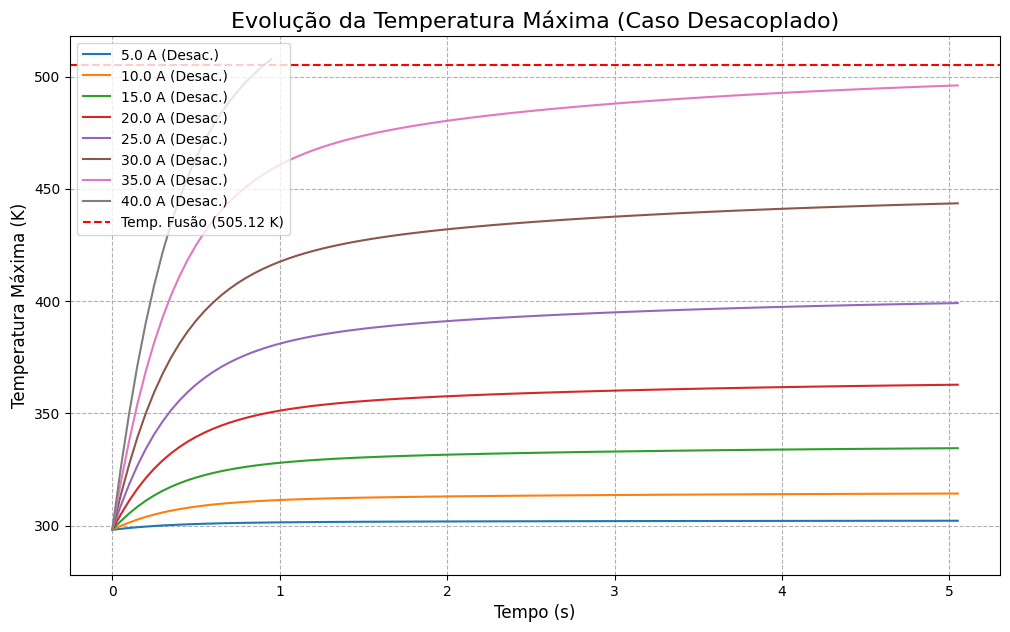

In [9]:
# =============================================================================
# 8. PLOT DO GRÁFICO TEMPO vs TEMPERATURA
# =============================================================================

plt.figure(figsize=(12, 7))
for current, (times, temps) in results.items():
    plt.plot(times, temps, label=f'{current:.1f} A (Desac.)')

plt.axhline(y=Tf, color='r', linestyle='--', label=f'Temp. Fusão ({Tf:.2f} K)')
plt.title('Evolução da Temperatura Máxima (Caso Desacoplado)', fontsize=16)
plt.xlabel('Tempo (s)', fontsize=12)
plt.ylabel('Temperatura Máxima (K)', fontsize=12)
plt.legend()
plt.grid(True, which='both', linestyle='--')
plt.ylim(bottom=T_amb-20)
plt.show()